# Scheduling Environement with OpenAI Gym 

### Case 1: Uniskill Agents and Uniservice call center

In [135]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from pyworkforce.queuing import ErlangC
import torch

In [136]:
def genArrivals():

        # Define arrival rate (e.g., 10 arrivals per hour)
        lambda_per_hour = 10

        # Define number of intervals in the day (48 intervals for 30-minute spacing over 24 hours)
        num_intervals = 48

        # Generate arrivals for each interval
        arrivals = np.random.poisson(lambda_per_hour / 2, num_intervals)

        # Generate time intervals
        time_intervals = pd.date_range(start="00:00:00", periods=num_intervals, freq="30T").time

        df=pd.DataFrame({'time':time_intervals,'arrivals':arrivals})

        df.to_csv("data/arrivals.csv")

def get_agents_schedule(shifts, shift_duration):
    # Convert shift duration to equivalent number of 30-min slots
    slots_for_shift = 2 * shift_duration

    # Initialize a dictionary
    agents_per_30mins_dict = {}

    # Function to convert index to HH:MM time format
    def index_to_time(index):
        hh = index // 2
        mm = (index % 2) * 30
        return f"{hh:02d}:{mm:02d}"

    # Function to convert HH:MM time to an index
    def time_to_index(time_str):
        hh, mm = map(int, time_str.split(":"))
        return 2 * hh + mm // 30

    # Ensure all time slots are present in the dict
    for i in range(48):
        time_key = index_to_time(i)
        agents_per_30mins_dict[time_key] = 0

    for count, time_str in shifts:
        start_index = time_to_index(time_str)
        for i in range(slots_for_shift):
            if start_index + i < 48:
                time_key = index_to_time(start_index + i)
                agents_per_30mins_dict[time_key] += count

    # Sort the dictionary by keys
    sorted_agents_dict = dict(sorted(agents_per_30mins_dict.items()))

    return sorted_agents_dict

In [137]:
def calculate_shift_extended(gk):
    # list of actions (number of agents, shift start time) for the whole episode
    shifts=gk

    # the duration of the shifts 
    shift_duration = 3 # 2 hours

    # this shows the number of agents for every 30 minutes
    shifts_extended = get_agents_schedule(shifts, shift_duration)
    return shifts_extended



def calculate_reward(gk,arrivals):
    """
    Calculate a service level reward. 

    Parameters:
    - gk (list): List of action (number of agents,start time) for an episode.
    - arrivals (list): List of of arrivals (calls volume for every 30 minutes).

    Returns:
    - The reward score.
    """
    
    shifts_extended=calculate_shift_extended(gk)
    
    # we calculate the service level (sl) for every 30 minutes then average them
    # sl is calculated using Erlang C by comparing the number of agents working and arrivals
    
    sl=[]
    for a,p in zip(list(arrivals.arrivals.values),list(shifts_extended.values())):

        if a>0 and p>0:
            erlang = ErlangC(transactions=a, asa=20/60, aht=2, interval=30, shrinkage=0)
            sl.append(erlang.service_level(positions=p))
    #         print("waiting probability",erlang.waiting_probability(positions=p))

        # the case where we have arrivals but no agents to handle them ---> sl==0
        if a>0 and p==0:
            sl.append(0)
            
    
    # Service Level: The expected percentage of transactions that don’t wait in the queue longer than the target ASA
    # Average speed of answer (ASA): Average time that a transaction waits in the queue to be attended by a resource
    # The requirement is fixed by the call center for service level is 80%
    # the reward score is arbitratry +30 and -30
    
    number_sl_violation=np.sum(np.array(sl)<0.80)
    number_sl_respected=np.sum(np.array(sl)>=0.80)
    
    reward=(number_sl_respected*30)+(number_sl_violation*-30)
            
            
    return reward
    
    
    

In [ ]:
arrivals=pd.read_csv("../data/arrivals.csv")
arrivals.head()

In [139]:

class scheduling(gym.Env):
    """ Scheduling Environment """

    

    def time_slots(self):
       # Define the start and end times for the day
        start_time = datetime.strptime("00:00", "%H:%M")
        end_time = datetime.strptime("23:59", "%H:%M")

        # Initialize a dictionary to store the index and time slot pairs
        time_slots_dict = {}

        # Generate time slots for every 30 minutes and store them with an index
        current_time = start_time
        index = 1
        while current_time <= end_time:
            time_slots_dict[index] = current_time.strftime("%H:%M")
            current_time += timedelta(minutes=30)
            index += 1

        # Example usage:
        # Print all index-time slot pairs
        # for index, time_slot in time_slots_dict.items():
        #     print(f"Index {index}: {time_slot}")

        return time_slots_dict


    def __init__(self,n_agents=11,n_services=1,n_shifts=6):
        super().__init__()

        # number of start time
        self.n_st=48
        # number of agents
        self.n_agents=n_agents
        #agent ids
        self.agents_ids=[i for i in range(1,self.n_agents)]

        # time slots
        self.ts=self.time_slots()
        # number of services
        self.n_services=n_services
        # number of shifts
        self.n_shifts=n_shifts

        # observation space
        self.observation_space = spaces.Discrete(n_services*n_shifts)
        self.observation_space=0
       
        # Action space 
        self.action_space = spaces.Tuple((
                    spaces.Discrete(self.n_agents),  # number of agents
                    spaces.Discrete(self.n_st),  # start time 
                
                ))
       
        # termination of episode condition
        self.terminated=False

        # list of action
        self.gk=[]


    def step(self, action,arrivals):
        
        # action number of agents
        action_n_agent=action[0]
        
        if self.terminated==False:
            # substract the dispatched agents from the total number of available agents 
            old=self.n_agents
            self.n_agents-=action_n_agent
            if self.n_agents<0:
                action_n_agent=old
                self.n_agents=0
                action=(action_n_agent,action[1]) 
            

        print("number of available agents",self.n_agents)

        if self.observation_space!=self.n_shifts-1:
            reward=0
            self.gk.append(action)
            print("observation_space is:",self.observation_space)
            print("reward is:",reward)
            self.observation_space+=1

            return self.observation_space, reward, self.terminated
        
        else:
            self.gk.append(action)
            reward=calculate_reward(self.gk,arrivals)
            print("observation_space is:",self.observation_space)
            print("reward is:",reward)
            print("shifts: ",self.gk)
            self.terminated=True
            return self.observation_space, reward, self.terminated

           
    
    def reset(self, n_agents=11,seed=None, options=None):
         self.observation_space=0
         self.gk=[]
         self.n_agents=n_agents
         

         self.terminated=False
    
    def render(self, V,mode='human'):
       pass



In [ ]:

# looping over multiple episodes
reward_list=[]
for _ in range(1000):
    s=scheduling(n_agents=20,n_services=1,n_shifts=10)
    t=False
    
    # Loop over an episode of 4 shift 
    while not t:

        # pick random number of agent
        if s.n_agents!=0:
             n_ag = random.randint(1, s.n_agents)

        else:
            n_ag=0

        # picking actions randomly (start time, nb_agents) here we should use a policy !
        values = list(s.ts.values())
        random_ts = random.choice(values)

        # step using random action 
        o,reward,t=s.step(action=(n_ag,random_ts),arrivals=arrivals)
        
    reward_list.append(reward)


In [ ]:
import matplotlib.pyplot as plt

# Your data
data = calculate_shift_extended(s.gk)

# Splitting the data into two lists: one for time and one for counts
times = list(data.keys())
counts = list(data.values())

# Creating the bar chart
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.bar(times, counts, color='blue')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Counts per 30-minute interval over a 24-hour period')
plt.tight_layout()  # Adjust the layout to prevent clipping of labels
plt.plot(arrivals['arrivals'])
print("The reward at the end of the episode is: ",reward)
print("The maximum reward we could get is:",48*30)
plt.show()  # Display the chart


In [ ]:
def moving_average(data, window_size=200):
    """
    Compute the moving average of a list.

    Parameters:
    - data (list or iterable): The input data.
    - window_size (int): The size of the moving average window.

    Returns:
    - list: The moving average values.
    """
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        avg = sum(data[i:i + window_size]) / window_size
        moving_avg.append(avg)
    return moving_avg


averaged_data = moving_average(reward_list)

plt.plot(averaged_data)
reward_list[-1],np.mean(reward_list),np.std(reward_list)

### On policy control with SARSA

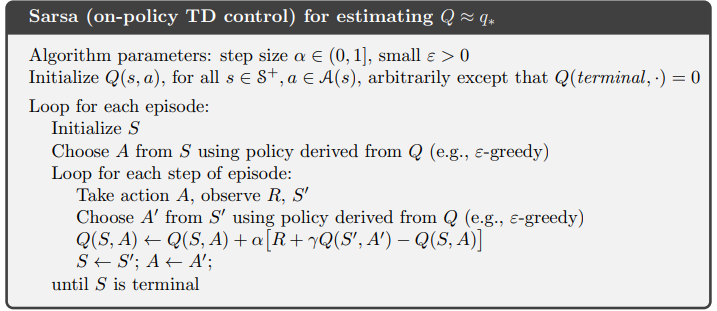

In [155]:
# reset environement
sc=scheduling(n_agents=20,n_services=1,n_shifts=10)

In [156]:
torch.manual_seed(42)
# initialize the Q(s,a)
Q=torch.rand((sc.n_shifts*sc.n_services,sc.n_agents,sc.n_st))
#Assuming we are at state 0
Q.shape

torch.Size([10, 20, 48])

In [157]:
def pi(s,Q,sc,eps=0.1):
    
    ### epislon greedy policy

    # lets generate a random number between 0 and 1
    
    explore=torch.rand(1)<eps
    print("Are we exploring: ",explore)

    if explore:
        if sc.n_agents!=0:
            if sc.n_agents==1:
                return (1,np.random.choice(sc.n_st))
                
            return np.random.choice(np.arange(1, sc.n_agents)),np.random.choice(sc.n_st)
        else:
            return (0,np.random.choice(sc.n_st))
           

    else:

        # Get the max value and its linear index
        argmax=((Q[s]==torch.max(Q[s])).nonzero())
        random_idx = torch.randint(0, argmax.size(0), (1,)).item()
        choice = argmax[random_idx]

        return choice[0].item(),choice[1].item()


In [146]:
pi(s=0,sc=sc,Q=Q,eps=0.1)

Are we exploring:  tensor([False])


(2, 14)

In [ ]:
# looping over multiple episodes
reward_list=[]
alpha=0.01
gamma=1
sc=scheduling(n_agents=20,n_services=1,n_shifts=10)
i_eps=2
for _ in range(100000):
    
    sc.reset(n_agents=20)
    t=False
    
    #decreasing epsilon
    
    # Loop over an episode of 4 shift 
    while not t:
        
        state=sc.observation_space
        print("state:", state)
        
        action=pi(s=state,Q=Q,eps=1/i_eps,sc=sc)

        # pick random number of agent
        if sc.n_agents!=0:
             n_ag = action[0]

        else:
            n_ag=0

        # picking actions randomly (start time, nb_agents) here we should use a policy !
        values = list(sc.ts.values())
        random_ts = values[action[1]]

        
        print("action:",(n_ag,random_ts))

        # step using epsilon greedy policy 
        state_prime,reward,t=sc.step(action=(n_ag,random_ts),arrivals=arrivals)
        
        # get the S' and update q-value
        action_prime=pi(s=state,Q=Q,eps=1/i_eps,sc=sc)
        print("action prime",action_prime)
        
        Q[state,action[0],action[1]]+=alpha*(reward+(gamma*Q[state_prime,action_prime[0],action_prime[1]])- Q[state,action[0],action[1]] )
        i_eps+=1
        
    print("##################################### iteration:",i_eps)    
    reward_list.append(reward)

In [148]:
Q.shape

torch.Size([10, 20, 48])

In [149]:
reward_list[-1],np.mean(reward_list),np.std(reward_list)

(-720, -706.938, 201.33113061819327)

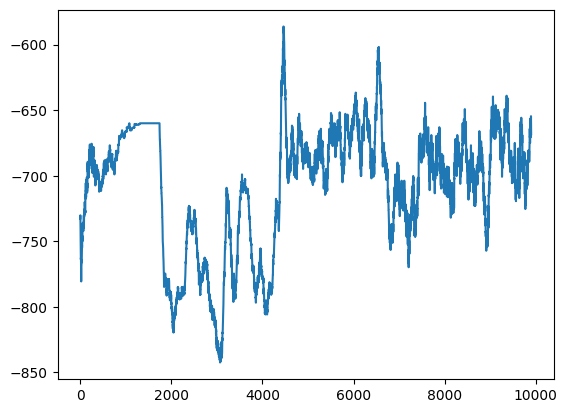

In [150]:
def moving_average(data, window_size=100):
    """
    Compute the moving average of a list.

    Parameters:
    - data (list or iterable): The input data.
    - window_size (int): The size of the moving average window.

    Returns:
    - list: The moving average values.
    """
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        avg = sum(data[i:i + window_size]) / window_size
        moving_avg.append(avg)
    return moving_avg


averaged_data = moving_average(reward_list)

plt.plot(averaged_data)


The reward at the end of the episode is:  -720
The maximum reward we could get is: 1440


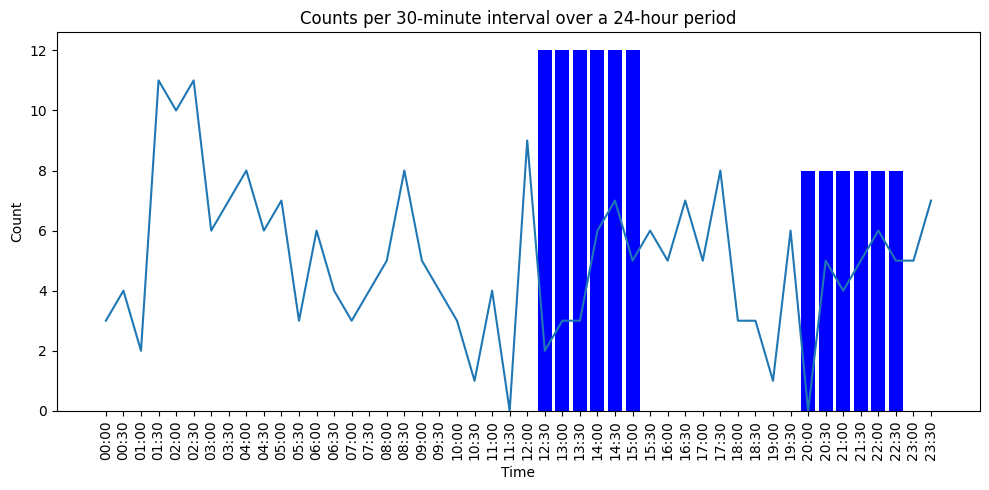

In [151]:
import matplotlib.pyplot as plt

# Your data
data = calculate_shift_extended(sc.gk)

# Splitting the data into two lists: one for time and one for counts
times = list(data.keys())
counts = list(data.values())

# Creating the bar chart
plt.figure(figsize=(10, 5))  # Set the figure size (optional)
plt.bar(times, counts, color='blue')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Counts per 30-minute interval over a 24-hour period')
plt.tight_layout()  # Adjust the layout to prevent clipping of labels
plt.plot(arrivals['arrivals'])
print("The reward at the end of the episode is: ",reward)
print("The maximum reward we could get is:",48*30)
plt.show()  # Display the chart

In [152]:
pi(s=3,Q=Q,sc=sc,eps=0.00001)

Are we exploring:  tensor([False])


(5, 35)

(array([ 94.,  88., 105.,  88.,  96.,  59.,  82.,  94.,  84., 170.]),
 array([0.00234562, 0.09161846, 0.18089129, 0.27016413, 0.35943696,
        0.44870979, 0.53798264, 0.62725544, 0.7165283 , 0.80580109,
        0.89507395]),
 <BarContainer object of 10 artists>)

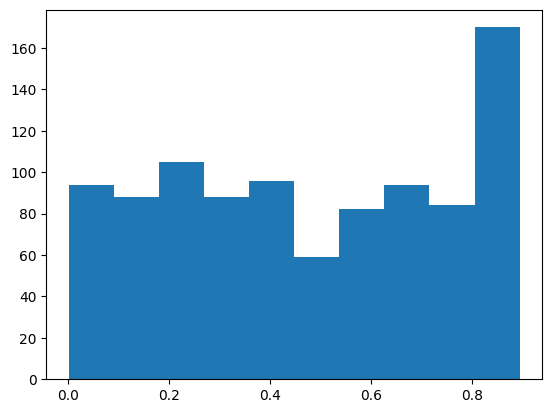

In [154]:
plt.hist(Q[0].view(1,-1))